In [409]:
import dataset as ds
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

### We select the cutoff for the "time since root tweet" limit in fetching tree data

In [410]:
CUTOFF = 1000

In [411]:
data_builder = ds.DatasetBuilder("twitter15", time_cutoff=CUTOFF)
dataset = data_builder.create_dataset(dataset_type="raw", standardize_features=False)

Considering only binary classification problem
We consider tweets emitted no later than 1000mins after the root tweet
Len train/val/test 500 75 167
Dataset loaded in 10.512s


In [412]:
raw_train = dataset['train']
raw_validate = dataset['val']

In [413]:
len(raw_train)

500

In [414]:
raw_train[0][0]

['true',
 509463933564891137,
 0,
 1,
 0.35,
 13461662,
 59897849,
 14449.0,
 8816.0,
 488.0,
 1372.0,
 0.0,
 1.0,
 13.0,
 9.0,
 38.0,
 11508.0,
 0.0]

In [415]:
edge_feature_names = ["created_at",
                    "favourites_count", 
                    "followers_count", 
                    "friends_count", 
                    "geo_enabled",
                    "has_description",
                    "len_name",
                    "len_screen_name",
                    "listed_count",
                    "statuses_count", 
                    "verified"
                     ]
edge_feature_names = sorted(edge_feature_names)
edge_feature_names = ["label",
                      "root_id",
                      "in_tweet_idx",
                      "out_tweet_idx",
                      "latency",
                      "in_uid",
                      "out_uid"] + edge_feature_names
n_cols = len(edge_feature_names)
n_cols

18

### We set the prediction latency level for our model: X minutes means our model classifies using features available X minutes after the root tweet is emitted 

In [416]:
PREDICTION_LATENCY = 350 # in minutes after the first tweet is emitted

In [417]:
def get_df_from_raw(raw_data):
    data_dict = {name:[] for name in edge_feature_names}
    for features_sequence in raw_data:
        for dp in features_sequence:
            for i in range(n_cols):
                data_dict[edge_feature_names[i]].append(dp[i])
    df = pd.DataFrame(data=data_dict)
    df.label = df.label.apply(lambda x: 1.0 if x=='true' else 0.)
    return df

In [418]:
df_train = get_df_from_raw(raw_train)
df_validate = get_df_from_raw(raw_validate)

In [419]:
df_train.head()

,label,root_id,in_tweet_idx,out_tweet_idx,latency,in_uid,out_uid,created_at,favourites_count,followers_count,friends_count,geo_enabled,has_description,len_name,len_screen_name,listed_count,statuses_count,verified
0,1.0,509463933564891137,0,1,0.35,13461662,59897849,14449.0,8816.0,488.0,1372.0,0.0,1.0,13.0,9.0,38.0,11508.0,0.0
1,1.0,509463933564891137,0,2,0.60,13461662,24253448,14316.0,1504.0,522.0,559.0,0.0,1.0,11.0,5.0,25.0,34455.0,0.0
2,1.0,509463933564891137,0,3,0.62,13461662,23700297,14314.0,10955.0,814.0,626.0,1.0,1.0,18.0,14.0,80.0,20996.0,0.0
3,1.0,509463933564891137,0,4,0.70,13461662,14631962,14001.0,45441.0,320.0,577.0,0.0,1.0,15.0,5.0,5.0,56195.0,0.0
4,1.0,509463933564891137,0,0,0.87,13461662,50256333,13923.0,8992.0,167394.0,821.0,1.0,1.0,14.0,13.0,2458.0,17804.0,1.0


In [420]:
len(df_train.in_tweet_idx.unique())

244

In [422]:
df_train.groupby('root_id').nunique().mean();

### Some univariate plots

In [423]:
def plot_numerical_user_value(df, user_col, log=False):
    values = df_train.groupby('out_uid').median()[user_col].values
    if log:
        values = np.log(values + 1)
    plt.hist(values)
    plt.grid()

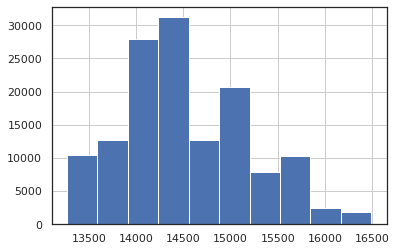

In [424]:
plot_numerical_user_value(df_train, 'created_at')

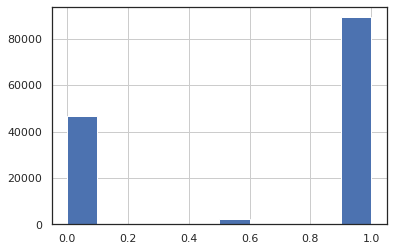

In [425]:
plot_numerical_user_value(df_train, 'verified')

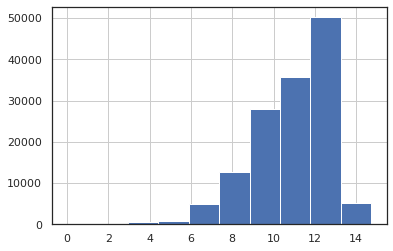

In [426]:
plot_numerical_user_value(df_train, 'statuses_count', log=True)

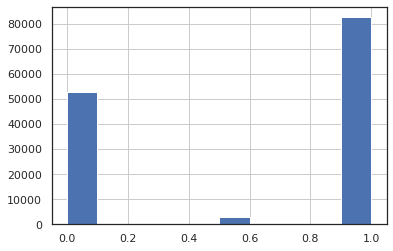

In [427]:
plot_numerical_user_value(df_train, 'geo_enabled')

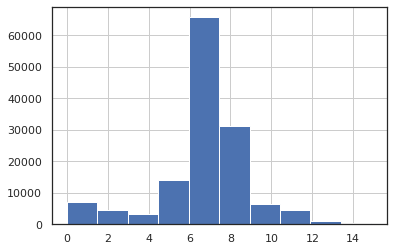

In [428]:
plot_numerical_user_value(df_train, 'friends_count', log=True)

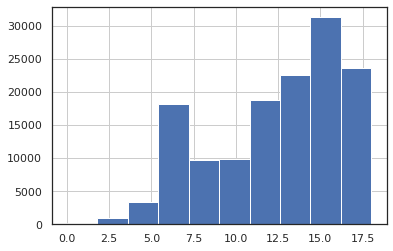

In [429]:
plot_numerical_user_value(df_train, 'followers_count', log=True)

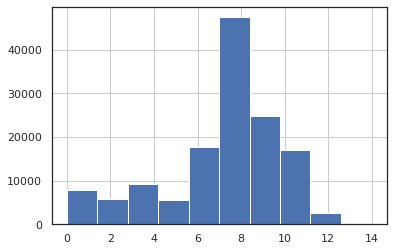

In [430]:
plot_numerical_user_value(df_train, 'favourites_count', log=True)

### Applying log transforms where needed

In [431]:
to_log = ['favourites_count', 'followers_count', 'friends_count', 'statuses_count']
for colname in to_log:
    df_train.loc[:, colname] = np.log(df_train.loc[:, colname].values + 1)
    df_validate.loc[:, colname] = np.log(df_validate.loc[:, colname].values + 1)

In [432]:
df_train.dtypes

label               float64
root_id               int64
in_tweet_idx          int64
out_tweet_idx         int64
latency             float64
in_uid                int64
out_uid               int64
created_at          float64
favourites_count    float64
followers_count     float64
friends_count       float64
geo_enabled         float64
has_description     float64
len_name            float64
len_screen_name     float64
listed_count        float64
statuses_count      float64
verified            float64
dtype: object

Filter first by latency prediction constraint

In [433]:
len(df_train.root_id.unique())

497

In [434]:
def cut_by_latency(df):
    df = df.loc[df.latency <= PREDICTION_LATENCY]
    return df

In [435]:
df_train = cut_by_latency(df_train)
df_validate = cut_by_latency(df_validate)

In [436]:
len(df_train.root_id.unique())

496

In [437]:
df_train.label.mean()

0.4466796421101557

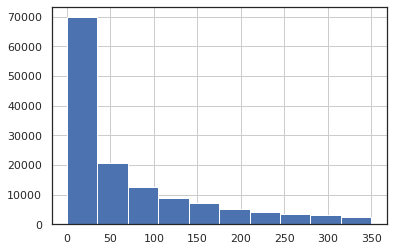

In [440]:
df_train.latency.hist()

First analysis based on a simple aggregation of the features by root_id
- in_tweet -> nunique
- latency -> mean
- in_uid -> nunique
- created_at -> mean
- followers_count -> mean
- favourites_count -> mean
- friends_count -> mean
- geo_enabled -> mean
- has_description -> mean
- statuses_count -> mean
- verified -> mean

In [441]:
df_train.columns

Index(['label', 'root_id', 'in_tweet_idx', 'out_tweet_idx', 'latency',
       'in_uid', 'out_uid', 'created_at', 'favourites_count',
       'followers_count', 'friends_count', 'geo_enabled', 'has_description',
       'len_name', 'len_screen_name', 'listed_count', 'statuses_count',
       'verified'],
      dtype='object')

In [442]:
cols_kept = [colname for colname in df_train.columns if colname not in ['len_name', 'len_screen_name', 'listed_count']]
cols_kept

['label',
 'root_id',
 'in_tweet_idx',
 'out_tweet_idx',
 'latency',
 'in_uid',
 'out_uid',
 'created_at',
 'favourites_count',
 'followers_count',
 'friends_count',
 'geo_enabled',
 'has_description',
 'statuses_count',
 'verified']

In [443]:
count_cols = ['out_tweet_idx', 'out_uid', 'in_tweet_idx', 'in_uid']

In [444]:
mean_cols = [colname for colname in cols_kept if colname not in count_cols]

In [445]:
sum_cols = []
sum_cols

[]

In [446]:
print(len(cols_kept), len(mean_cols), len(count_cols), len(sum_cols))

15 11 4 0


In [447]:
df_train = df_train[cols_kept]
df_validate = df_validate[cols_kept]

In [448]:
df_train.head()

,label,root_id,in_tweet_idx,out_tweet_idx,latency,in_uid,out_uid,created_at,favourites_count,followers_count,friends_count,geo_enabled,has_description,statuses_count,verified
0,1.0,509463933564891137,0,1,0.35,13461662,59897849,14449.0,9.084437,6.192362,7.224753,0.0,1.0,9.350885,0.0
1,1.0,509463933564891137,0,2,0.60,13461662,24253448,14316.0,7.316548,6.259581,6.327937,0.0,1.0,10.447438,0.0
2,1.0,509463933564891137,0,3,0.62,13461662,23700297,14314.0,9.301643,6.703188,6.440947,1.0,1.0,9.952135,0.0
3,1.0,509463933564891137,0,4,0.70,13461662,14631962,14001.0,10.724192,5.771441,6.359574,0.0,1.0,10.936601,0.0
4,1.0,509463933564891137,0,0,0.87,13461662,50256333,13923.0,9.104202,12.028112,6.711740,1.0,1.0,9.787235,1.0


In [449]:
def aggregation_v0(df):
    aggregations_dict = {name:'sum' for name in sum_cols}
    aggregations_dict.update({name: 'mean' for name in mean_cols})
    aggregations_dict.update({name: 'nunique' for name in count_cols})
    aggregated_data = df.groupby('root_id').agg(aggregations_dict)
    aggregated_data = aggregated_data.reset_index(drop=True)
    aggregated_data = aggregated_data.drop(columns='root_id')
    return aggregated_data

In [450]:
intermediate_levels = [75, 150, PREDICTION_LATENCY]
latency_bins = list(range(len(intermediate_levels)))

In [451]:
def to_latency_bin(x):
    for ix, latency_level in enumerate(intermediate_levels):
        if x <= latency_level:
            return latency_bins[ix]
    return latency_bins[-1]

In [452]:
def aggregation_v1(df):
    aggregations_dict = {name:'sum' for name in sum_cols}
    aggregations_dict.update({name: 'mean' for name in mean_cols})
    aggregations_dict.update({name: 'nunique' for name in count_cols})
    df.loc[: , 'indexer_latency'] = df.latency.apply(to_latency_bin)
    aggregated_data = df.groupby(['root_id', 'indexer_latency']).agg(aggregations_dict)
    aggregated_data = aggregated_data.drop(columns='root_id')
    aggregated_data = aggregated_data.unstack(level=-1).dropna(axis=0, how='any')
    aggregated_data.columns = ['_'.join([str(x) for x in col]) for col in aggregated_data.columns.values]
    aggregated_data = aggregated_data.drop(columns=['label_{}'.format(i) for i in range(1, len(intermediate_levels))])
    aggregated_data = aggregated_data.rename(columns={"label_0":"label"})
    aggregated_data = aggregated_data.reset_index(drop=True)
    return aggregated_data

In [453]:
def aggregation_v0(df):
    aggregations_dict = {name:'sum' for name in sum_cols}
    aggregations_dict.update({name: 'mean' for name in mean_cols})
    aggregations_dict.update({name: 'nunique' for name in count_cols})
    aggregated_data = df.groupby('root_id').agg(aggregations_dict)
    aggregated_data = aggregated_data.reset_index(drop=True)
    aggregated_data = aggregated_data.drop(columns='root_id')
    return aggregated_data

### We aggregate the features as planned and fit a GB with Decision Trees model, evaluate its ROC-AUC perf on val

In [454]:
df_train = aggregation_v0(df_train) # user v1 if you want to make several aggregations binned by latency level
df_validate = aggregation_v0(df_validate)

In [455]:
len(df_train)

496

In [456]:
df_train.head()

,label,latency,created_at,favourites_count,followers_count,friends_count,geo_enabled,has_description,statuses_count,verified,out_tweet_idx,out_uid,in_tweet_idx,in_uid
0,0.0,41.045604,13584.000000,7.038784,16.099901,7.931644,1.000000,1.000000,12.788235,1.000000,1,91,1,4
1,0.0,40.494248,13584.000000,7.038784,16.099901,7.931644,1.000000,1.000000,12.788235,1.000000,1,113,1,4
2,0.0,56.026618,14500.985294,9.744157,13.323220,7.885490,0.848039,0.936275,10.445796,0.730392,51,198,1,7
3,0.0,53.227647,13962.222910,0.799264,16.036361,2.766206,0.003096,0.996904,11.132748,0.981424,7,323,1,9
4,0.0,42.627356,13948.118541,0.738811,16.142224,2.736715,0.009119,0.996960,11.145932,0.990881,4,329,1,5


In [457]:
def binned_plot(data, feature_col, target_col, nquantiles=5):
    feature_vals = data.loc[:, feature_col].values
    target_vals = data.loc[:, target_col].values
    quantiles_to_compute = np.linspace(0, 1, num=nquantiles+2)
    bin_edges = np.quantile(feature_vals, q=quantiles_to_compute)
    nx, _ = np.histogram(feature_vals, bins=bin_edges)
    sum_x, _ = np.histogram(feature_vals, bins=bin_edges, weights=feature_vals)
    sum_y, _ = np.histogram(feature_vals, bins=bin_edges, weights=target_vals)
    plt.plot(sum_x / nx, sum_y/nx, color='black')
    plt.xlabel('Feature {}'.format(feature_col))
    plt.ylabel('Target mean')
    plt.ylim(target_vals.min(), target_vals.max())
    plt.grid()
    plt.show()
    plt.close()

### Binned Plots: they let us see how predictive our features are of the label

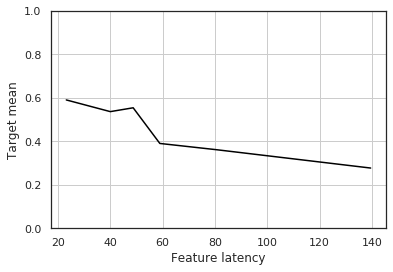

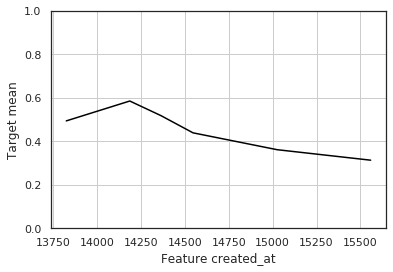

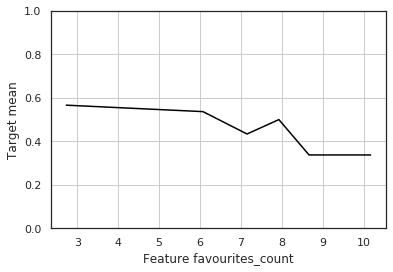

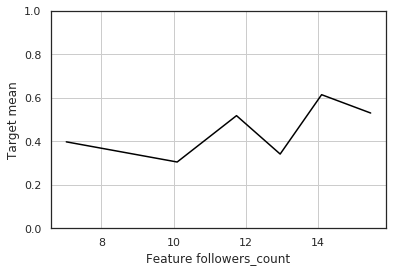

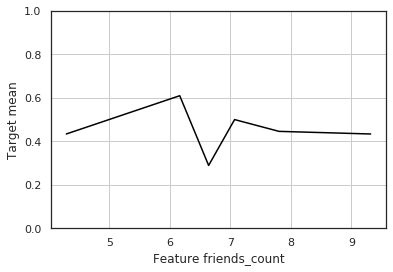

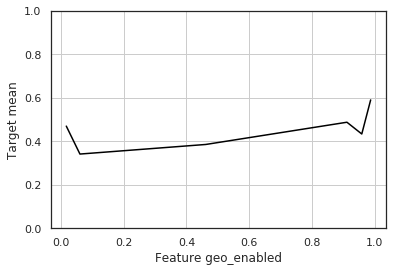

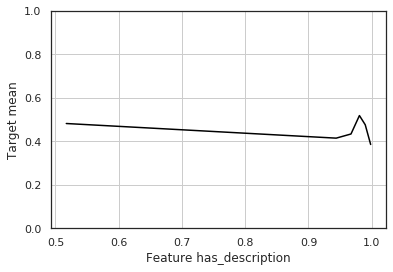

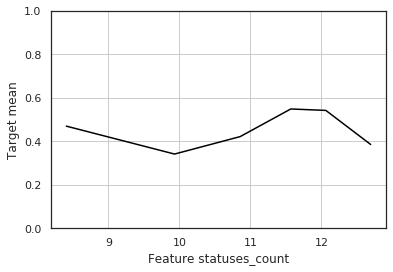

/home/arnaud15/miniconda3/envs/snap/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


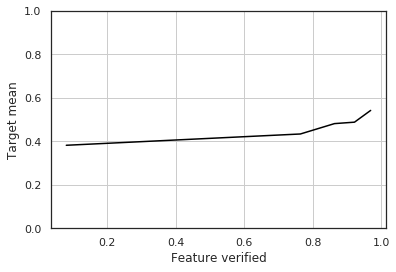

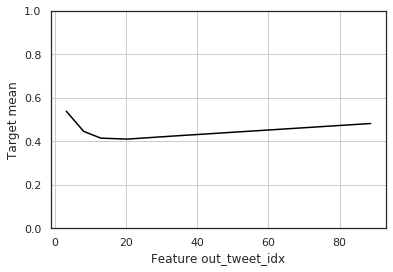

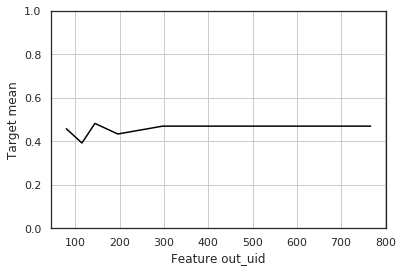

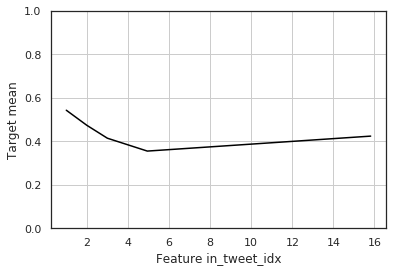

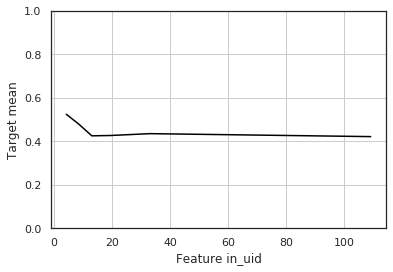

In [458]:
[binned_plot(df_train, col, 'label') for col in df_train.columns if col != 'label'];

### No clear trend above, for any feature, we snity check with a correlation heatmap that -unsurprisingly- will be as pale

In [459]:
sns.set(style="white")

In [460]:
def generate_corr_heatmap(df):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Correlations heatmap

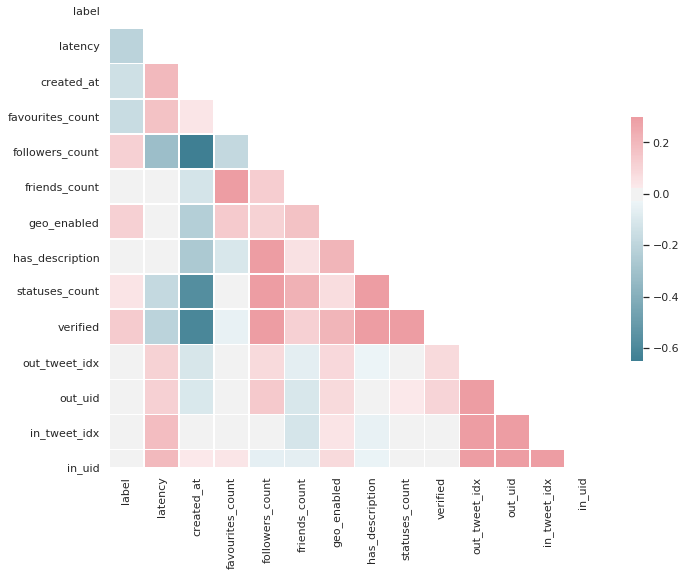

In [461]:
generate_corr_heatmap(df_train)

### We check the performance of a LightGBM GBDT model would do in terms of corss validation ROC-AUC score 

In [464]:
def lgb_eval_and_fit(df):
    X = df.drop(columns=["label"])
    y = df.label
    kf = KFold(n_splits=5, shuffle=False)
    len_ = X.values.shape[0]

    lgb_classifier = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=5, learning_rate=0.05, n_estimators=100, class_weight='balanced')


    scores_lgb = []
    for train_index, test_index in kf.split(np.arange(len_)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        lgb_classifier.fit(X_train, y_train)
        y_pref_lgb = lgb_classifier.predict(X_test)
        scores_lgb.append(roc_auc_score(y_test, y_pref_lgb))
    print("5-fold mean ROC AUC score for lightgbm: {:.5f}".format(sum(scores_lgb) / len(scores_lgb)))

    lgb_classifier.fit(X, y)
    return lgb_classifier

In [465]:
lgb_model = lgb_eval_and_fit(df_train)

5-fold mean ROC AUC score for lightgbm: 0.51413


### Feature importance

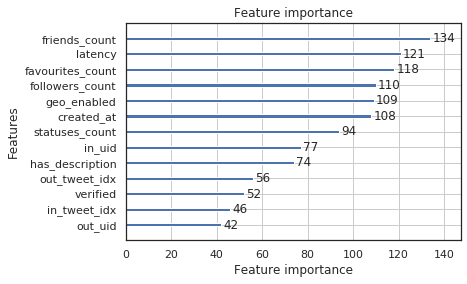

In [466]:
lgb.plot_importance(lgb_model)

### Score on val
- Val is very small so score is not to be trusted too much
- We shouldn't touch at test yet

In [469]:
X_val = df_validate.drop(columns='label')
y_val = df_validate.label
predictions_val = lgb_model.predict(X_val)
print("ROC AUC score on val: {:.5f}".format(roc_auc_score(y_val, predictions_val)))

ROC AUC score on val: 0.66987
